# Finding/opening ACCESS-OM3 output using intake

This notebook demonstrates how to using intake-esm to find and load data data from an ACCESS-OM3 run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [1]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

### USER EDIT start
# esm_file = "/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_ryf-1.0-beta/experiment_datastore.json"
# esm_file='/g/data/ol01/outputs/access-om3-25km/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file='/g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json'
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-paper-figs/"
os.makedirs(plotfolder, exist_ok=True)

# needed for mkmd START 
notebooks_dir = os.path.join(f"/g/data/tm70/{os.environ['USER']}/access-om3-paper-1", "notebooks")
os.chdir(notebooks_dir)
notebook_name=os.path.basename(os.environ.get("JPY_SESSION_NAME"))
print("Changed working directory to:", os.getcwd())
print("Notebook name is:", notebook_name)
from mkfigs_configdoc import mkmd
## example usage (note if the first argument to mkmd remains the same, you can insert multiple figures from the same notebook): 
#plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
#mkmd("Template notebook","`"+notebook_name+"`: Example figure of another type.",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')
# needed for mkmd STOP

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

Changed working directory to: /g/data/tm70/cyb561/access-om3-paper-1/notebooks
Notebook name is: 00_template_notebook.ipynb
ESM datastore path:  /g/data/ol01/outputs/access-om3-25km/MC_25km_jra_iaf-1.0-beta-5165c0f8/datastore.json
Plot folder path:  /g/data/tm70/cyb561/access-om3-paper-figs/


In [2]:
IAF = esm_file.find('iaf') > 0
IAF

True

In [3]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [4]:
client = Client(threads_per_worker=1)
print(client.dashboard_link)

/proxy/8787/status


### Open the intake-esm datastore

In [5]:
COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [6]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [7]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon", variable="umo")

available_variables(datastore_filtered)

,variable_long_name,variable_standard_name,variable_cell_methods,variable_units
variable,,,,
average_DT,Length of average period,,,days
average_T1,Start time for average period,,,days since 1900-01-01 00:00:00
average_T2,End time for average period,,,days since 1900-01-01 00:00:00
nv,vertex number,,,
rho2_i,Target Potential Density at interface,,,kg m-3
rho2_l,Target Potential Density at cell center,,,kg m-3
time,time,,,days since 1900-01-01 00:00:00
time_bnds,time axis boundaries,,,days since 1900-01-01 00:00:00
umo,Ocean Mass X Transport,ocean_mass_x_transport,rho2_l:sum yh:sum xq:point time: mean,kg s-1


### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [8]:
zos = datastore.search(variable="zos", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


/g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkmd/00_template_notebook1.png


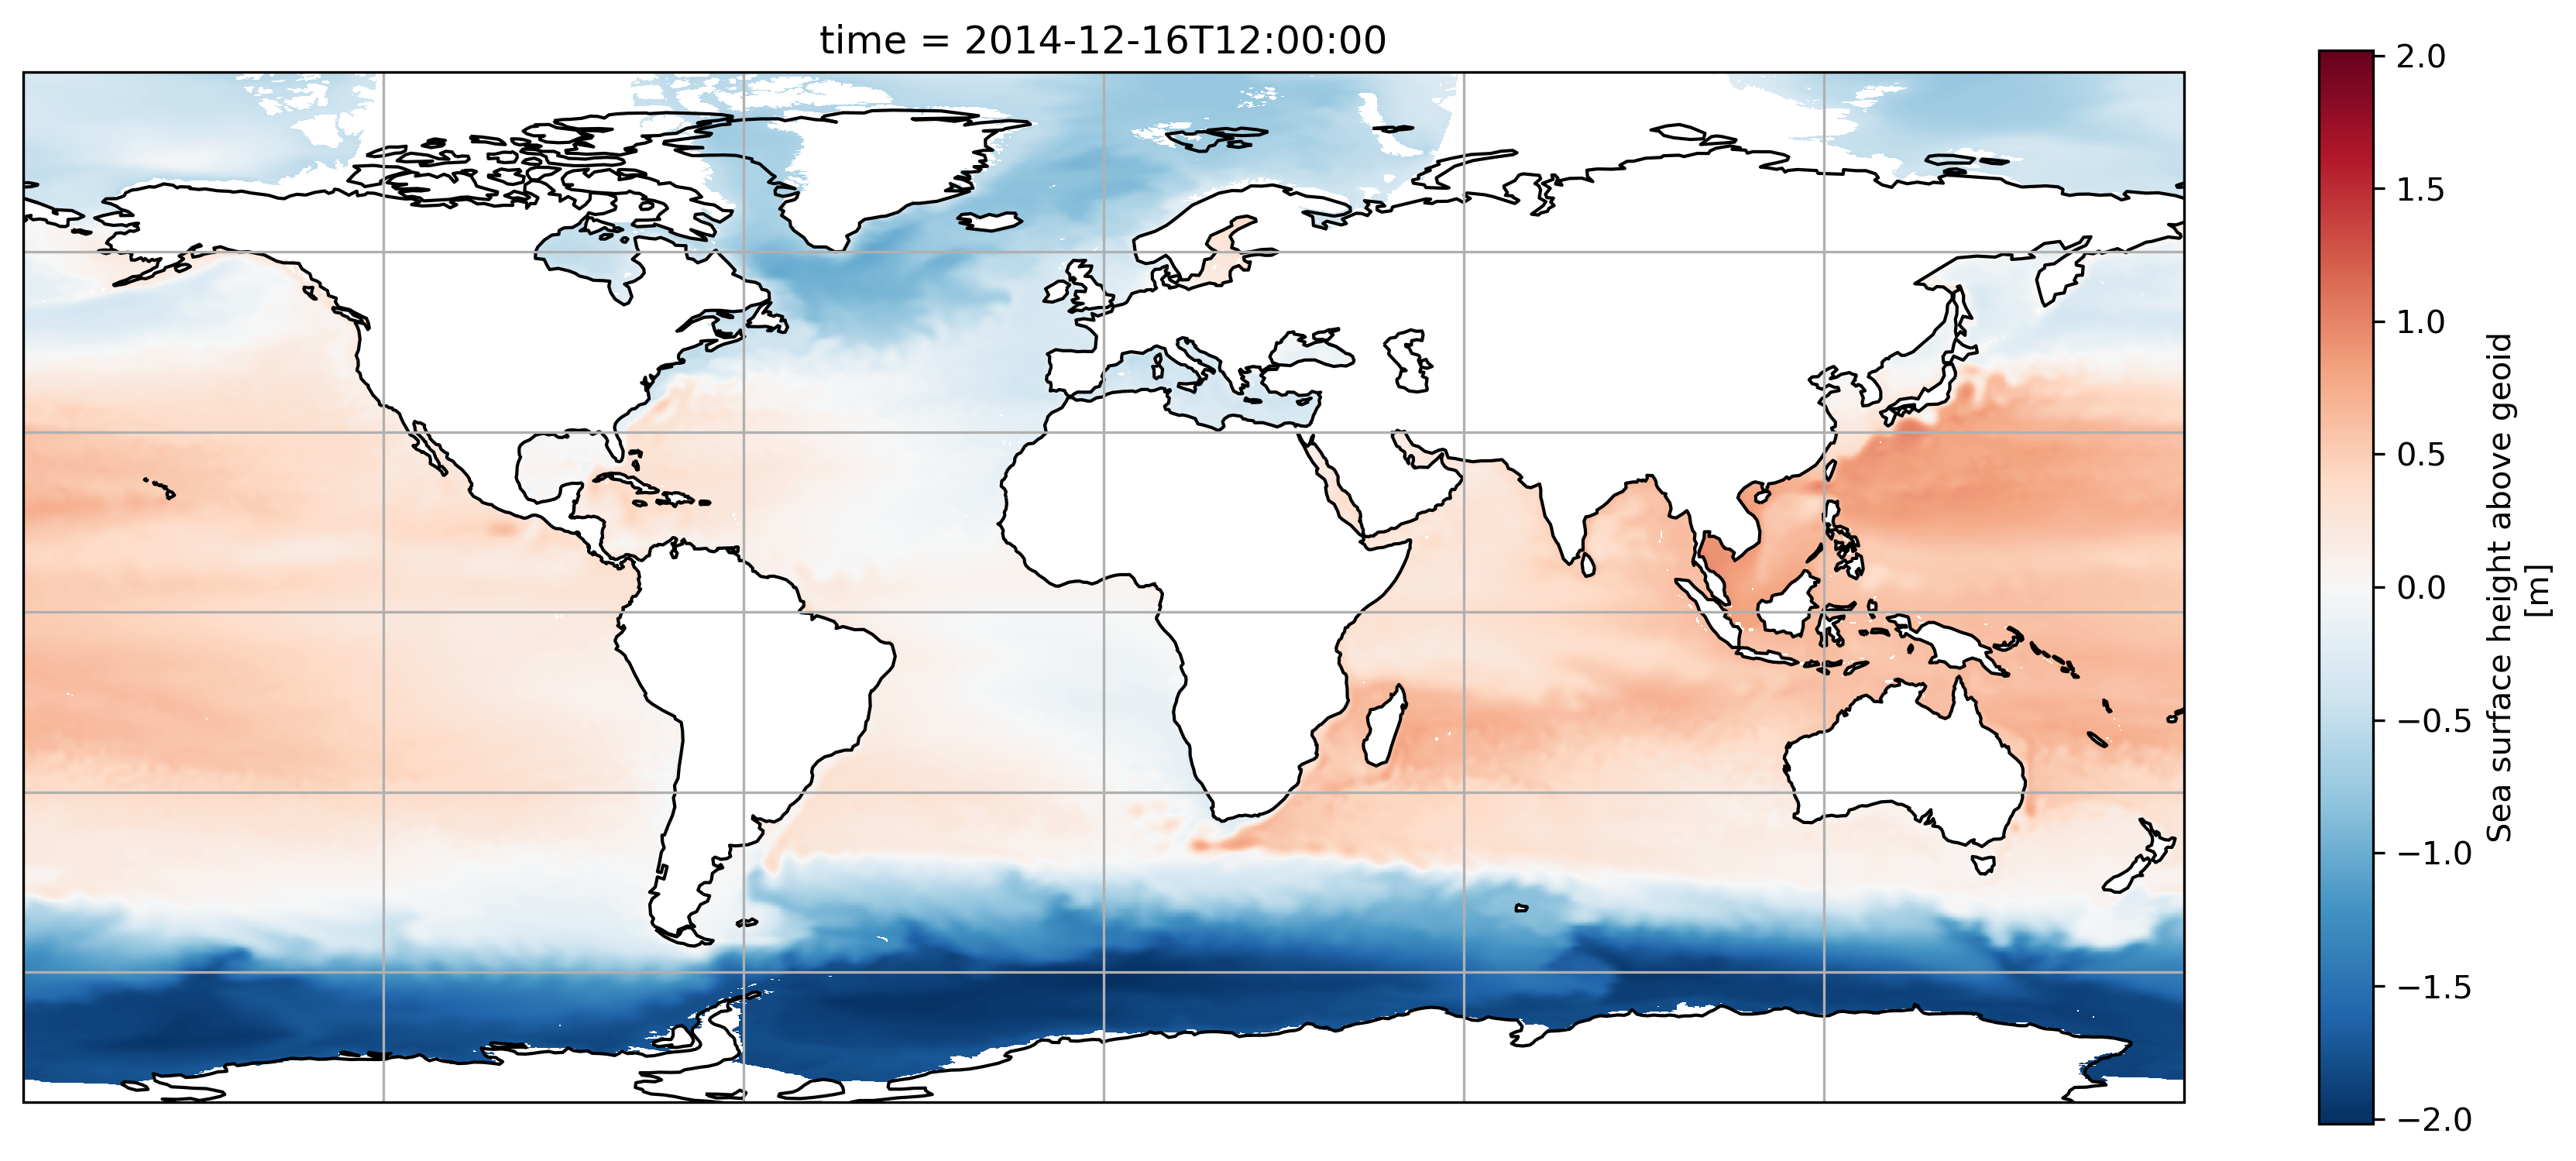

In [9]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

plt.savefig(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png', dpi=300, bbox_inches='tight')
print(notebooks_dir+'/mkmd/'+notebook_name[:-6]+'1.png')

In [10]:
mkmd("Template notebook","`"+notebook_name+"`: Example figure of ACCESS-OM3 sea surface height (m).",os.path.basename(os.path.dirname(esm_file)),notebook_name[:-6]+'1.png',notebooks_dir+'/mkmd/')

Adding a figure to markdown doc: /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkmd/MC_25km_jra_iaf-1.0-beta-5165c0f8.md
Lines appended to /g/data/tm70/cyb561/access-om3-paper-1/notebooks/mkmd/MC_25km_jra_iaf-1.0-beta-5165c0f8.md successfully.



#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that in some cases `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [11]:
try:
# preferred source, if available (no processor masking holes)
    coords = datastore.search(variable=["geolat", "geolon"], filename="access-om3.mom6.geometry.nc").to_dask().compute()
    coords = coords.rename({ "lonh": "xh", "lath": "yh" })
except ValueError:
# these contain NaNs in processor masks, so set NaNs to zero so they can be used for plotting
    coords = datastore.search(variable=["geolat", "geolon"], filename="access-om3.mom6.static.nc").to_dask().compute()
    coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


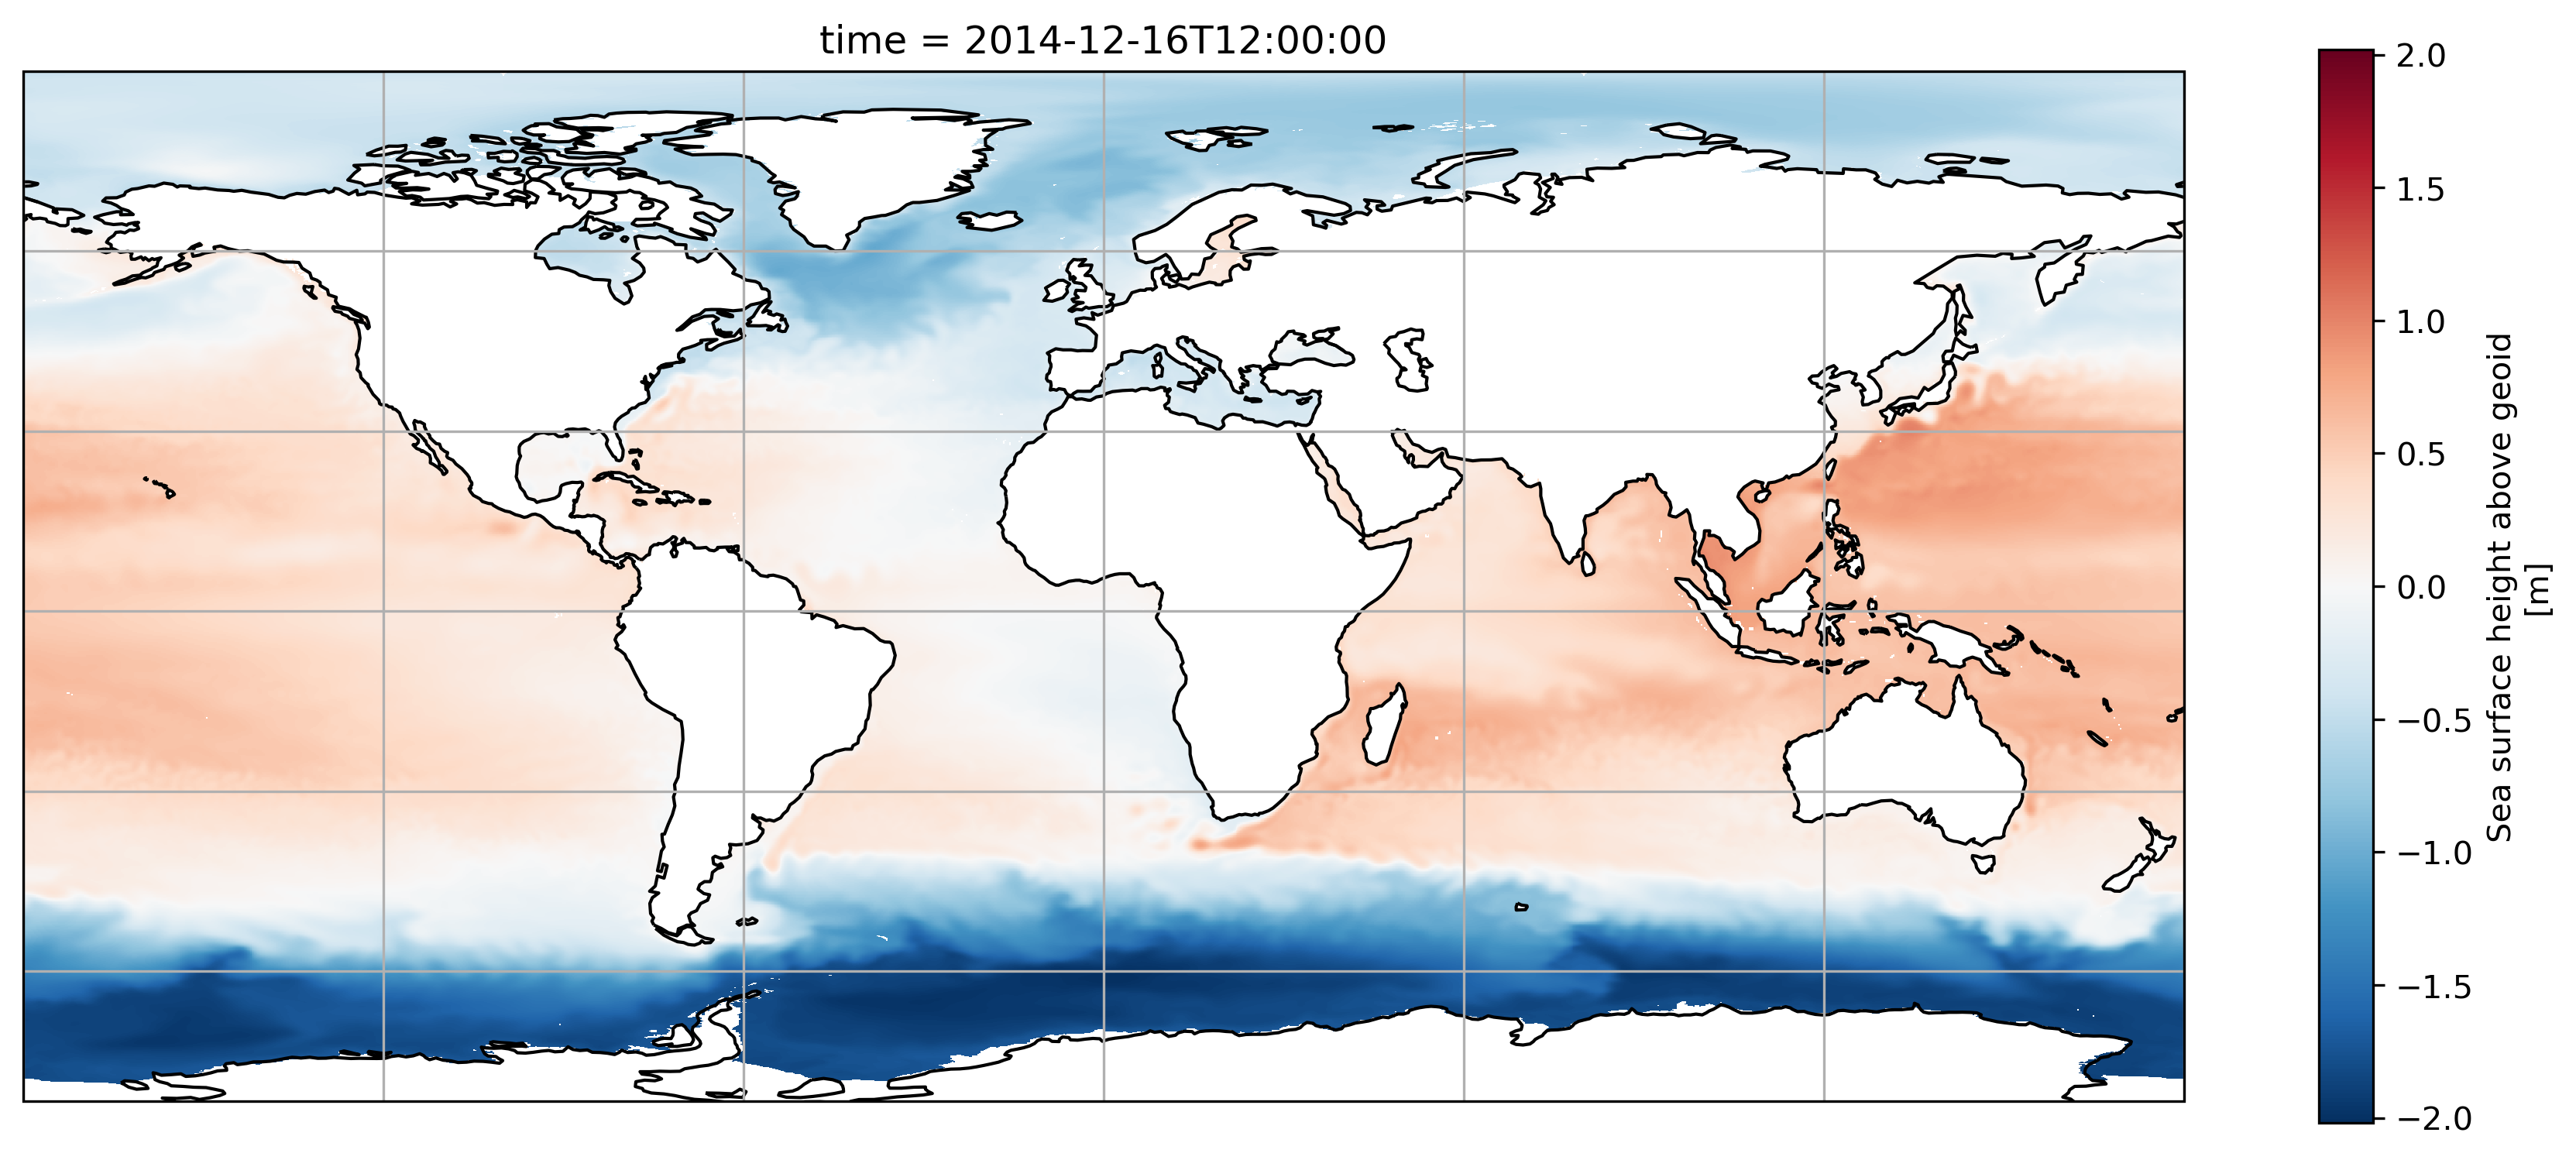

In [12]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [13]:
client.close()